2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [113]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
from IPython.display import Image

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [3]:
uniqueUsers = userArtistDF.select("userID").distinct().count()
print("Total n. of users: ", uniqueUsers)


Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [4]:
uniqueArtists = userArtistDF.select("artistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)


Total n. of artists:  1631028


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [5]:

userArtistDF.agg(min("userID"),max("userID")).show()

+-----------+-----------+
|min(userID)|max(userID)|
+-----------+-----------+
|         90|    2443548|
+-----------+-----------+



<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
The max value of userID conforms to the requirement of Integer.MAX_VALUE (or 2147483647). Assuming the userIDs are successively attributed, we notice that the  number of users (148,111) is much lower than the maximum Id value (2443548) which can be explained by the fact users that haven't been listed haven't listened to any artist yet. 
</div>

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [6]:
userArtistDF.agg(min("artistID"),max("userID")).show()

+-------------+-----------+
|min(artistID)|max(userID)|
+-------------+-----------+
|            1|    2443548|
+-------------+-----------+



<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
The max value of artistID conforms to the requirement of Integer.MAX_VALUE (or 2147483647). 
The artist data has the same problem that we noticed for users in that; the total numbers of artists listed in our file (1631028) is much lower than the highest ID value (10794401). 
Assuming sequential assignment of IDs, the missing artists do not seem to have an audience for the moment. 
<br>
Also, considering the ratio between the number of users listed and the maximum userId, and the one between the number of artists listed and the maximum artisId we find that:
<br>
<br>
    ratio_user= Max Value of UserID/No. of unique Users = 16,5 
    <br>
    ratio_artist= Max Value of ArtistID/No. of unique Artists = 6,6
<br>
<br>
This seems to be logical since being an artist is restrictive (an artist is added by last.fm world masters) while a lot more of users can create accounts without listening to music.
</div>

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

[Row(userID=1000061, sum(playCount)=244), Row(userID=1000070, sum(playCount)=20200), Row(userID=1000313, sum(playCount)=201), Row(userID=1000832, sum(playCount)=1064), Row(userID=1000905, sum(playCount)=214)]
+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|2129111|           523|
|2130165|             5|
|2133268|          1135|
|2134210|           558|
|2134480|          1702|
+-------+--------------+
only showing top 5 rows



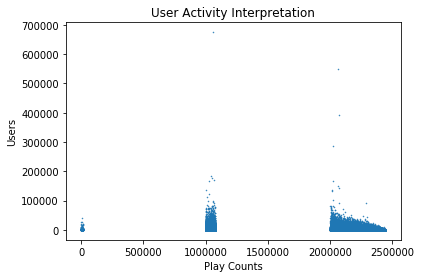

In [7]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy("userID").sum("playCount").collect()
print(userActivity[0:5])

#We decided to use show to have a better visualization of the result
userActivityShow = userArtistDF.groupBy("userID").sum("playCount").show(5)

#Function to plot playCount interpretation plots for user and artist 
def playCountPlots(list_name, x_label, y_label, plot_title):
    plt.plot(list(zip(*list_name))[0], list(zip(*list_name))[1], 'o', markersize=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.show()

#Plotting playCount interpretation plot for user
playCountPlots(userActivity, 'Play Counts', 'Users', 'User Activity Interpretation')

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
We see that playcounts of users have large variations ranging from 1 to 439771. Since there is no duration information available, it is not reasonable to conclude how the playcounts vary with different users. As an example , if the user is new or old, playcount values would depend on this (in this case a user with playcount=1 could be assumed to be a new user).
<br>
This can also be seen in the graph above. <br>Assuming sequential assignment of user IDs; which implies, old users have lower ID 'values'. So, the playcounts are more concentrated at the lower end of the plot (the old users' IDs.
<br>Newer users tend to have lower playcount values and we can also see some outliers - new users with fairly high playcounts of  at the upper end of the graph which implies that the new user might be highly active.  
</div>

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

In [8]:
#A function to plot CDF with parameters Y, yvals, maxXLim: the xmax of xlim, and logScale which is a boolean to plot CDF using a log scale or not
def plotFig(Y, yvals, userID, maxXLim, logScale=False):
    fig=plt.figure(figsize=(10,5))
    plt.step( Y, yvals )
    plt.xlabel('Play Counts')
    plt.ylabel('ECDF')
    plt.grid(True,which="both",ls="-")
    
    if logScale:
        ax=plt.gca()
        ax.set_xscale("log")
        ax.yaxis.set_ticks(np.arange(0,1.25,0.25))
        plt.title('ECDF of number of play counts per'+ userID+'-logarithmic scale')
    else:  
        plt.title('ECDF of number of play counts per'+ userID)
        plt.xlim(0,maxXLim)
    plt.show()
    
#A function to show the important percentiles. The parameter category is either user or artist
def Percentiles(Y, category):
    percentiles = [0.25,0.50,0.75,0.90]
    for x in percentiles:
        print(int(x*100),"% of "+category+ " listened to less than",Y[np.where(yvals>=x)[0][0]], "playcounts") #Y[index] where index=np.where(yvals>=x)[0][0]
    print('The maximum value of play counts per '+category+ ' is', Y[-1])

[     0      1      2 ... 148108 148109 148110]


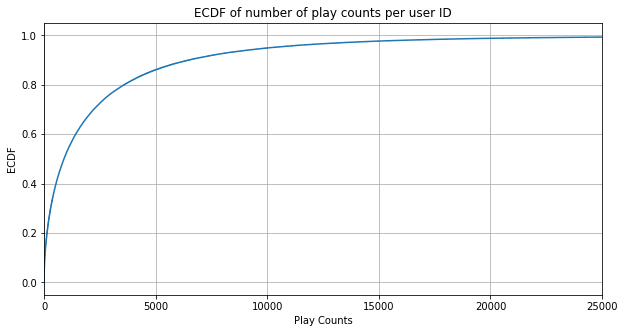

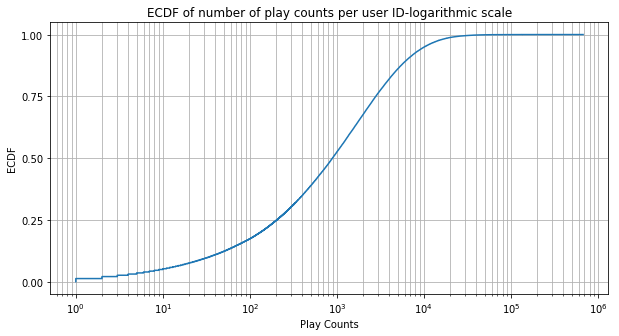

25 % of users listened to less than 204 playcounts
50 % of users listened to less than 892 playcounts
75 % of users listened to less than 2800 playcounts
90 % of users listened to less than 6484 playcounts
The maximum value of play counts per users is 674412


In [9]:
#Create the dataframe to compute x and y values
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

#Plot ECDF of number of play counts per userID 
plotFig(Y, yvals, ' user ID', 25000)
#Plot ECDF of number of play counts per userID with a logarithmic scale
plotFig(Y, yvals, ' user ID',25000, True)


Percentiles(Y, "users")
# userArtistDF.agg(sum('playCount')).withColumnRenamed("sum(playCount)", "Total_number_of_playcounts").show()


<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
Since the total number of play counts is too large (371638969) compared to the number of play counts most of the users have, we limited the number of playcounts on the x_axis to 25000 in order to focus on the transition part of the plot before it converges to value of 1.

We improved the visualization of the ECDF by using the logarithmic scale in the second figure.
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

+--------+--------------+
|artistID|sum(playCount)|
+--------+--------------+
| 1109864|          5293|
| 1021335|         38933|
| 2121200|           853|
| 1010728|         45373|
| 1000311|          8123|
+--------+--------------+
only showing top 5 rows



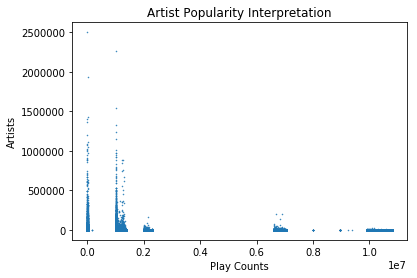

In [10]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularityDF = userArtistDF.groupBy("artistID").sum("playCount")
artistPopularity=artistPopularityDF.collect()
artistPopularityShow=artistPopularityDF.show(5)

#Plotting playCount interpretation plot for artist 
playCountPlots(artistPopularity, 'Play Counts', 'Artists', 'Artist Popularity Interpretation')

## Data Visualisation using Tableau Software

<div class="alert alert-success">

Those figures below were made using the software Tableau.
here is the link to the online version, which contains additional features of tableau that couldn’t be included in the notebook. For instance, we can check the artist_id and the corresponding data for each circle.

<b><div class="label label-success">Link for the first tableau representation:</div></b> 
<br>
https://dub01.online.tableau.com/t/missaouiml/views/artistID_totalPlayCounts/Sheet1?iframeSizedToWindow=true&:embed=y&:showAppBanner=false&:display_count=no&:showVizHome=no
<br>

<b><div class="label label-success">Link for the second tableau representation:</div></b> 
<br>
https://dub01.online.tableau.com/t/missaouiml/views/test_userID_totalPlayCounts/audienceSize?iframeSizedToWindow=true&:embed=y&:showAppBanner=false&:display_count=no&:showVizHome=no
<br>
 
</div>

In [121]:

%%HTML
<script type='text/javascript' src='https://dub01.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1440px; height: 810px;'><object class='tableauViz' width='1440' height='810' style='display:none;'><param name='host_url' value='https%3A%2F%2Fdub01.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;missaouiml' /><param name='name' value='artistID_totalPlayCounts&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>


<div class="alert alert-success">

## 1st Tableau Representation:

<br>
<b><div class="label label-success">Plot description:</div></b> 
The first one shows the total play count for each artist_ID.
 The artist_IDs are distributed in the figure in a way that the smallest ids are in the center of the figure, and they keep increasing as long as the points get far from the center.
Each artist_ID is represented by a circle which radius is  proportional to the total number of play counts for that given artist.

<br>

<b><div class="label label-success">Plot interpretation:</div></b> 
Assuming that the aritst_Ids are chronologically updated, ie the oldest artist has the smallest Id and the newest one has the biggest Id, this representation shows that almost all the biggest circles are located in the center of the figure where the ids are the smallest, ie the artists are the oldest. As we move far from the center where the artists are newly added, most of circles are smaller. This seems to be logical as the newest artists are likely to have less number of play count than the oldest ones. As for the exceptions, we believe that some new artists have the buzz which explains the large number of play counts.
<br>
 
</div>

In [122]:
%%HTML
<script type='text/javascript' src='https://dub01.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1440px; height: 810px;'><object class='tableauViz' width='1440' height='810' style='display:none;'><param name='host_url' value='https%3A%2F%2Fdub01.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;missaouiml' /><param name='name' value='test_userID_totalPlayCounts&#47;audienceSize' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>

<div class="alert alert-success">

## 2nd Tableau Representation:

<br>
<b><div class="label label-success">Plot description:</div></b> 
The second one shows the total number of users for each artist.
 The artist_IDs are distributed in the same way as explain above.
Each artist_ID is represented by a circle which radius is  proportional to the total number of users that have listened to that given artist.


<br>

<b><div class="label label-success">Plot interpretation:</div></b> 
Always under the assuming that the aritst_Ids are chronologically updated, this representation shows that the newest artists don’t have that many audience as the older ones. Although the discrimination between the different parts of the figure is less important than the first figure .
<br>
 
</div>

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
Assuming IDs are sequentially assigned, there is a greater concentration of older artists (although, we may assume that data for certain intermediate IDs may be unavailable) and the older artists are the ones that tend to me the most popular (as per playcounts). <br>
In the tableau graph, the circle represents the artists and the size of the circles the total playcounts for each artist. Assuming sequential assignment of artistIDs, the center of the circle has the least artistID value and as per of our assumptions, this correspond to the oldest artists. The dots on the circumference represent the newest artists. <br>
It is logical that older artists have a larger number of users playcounts. This can be seen in the interior of the circle. Also there exists outliers who are new artists with large playcounts.  This sometimes happens for artists or songs that go viral on the internet.
</div>

[      0       1       2 ... 1631025 1631026 1631027]


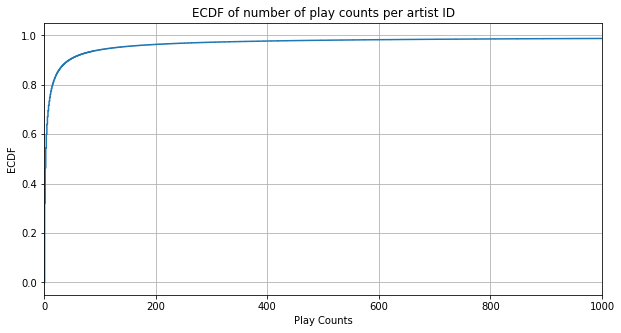

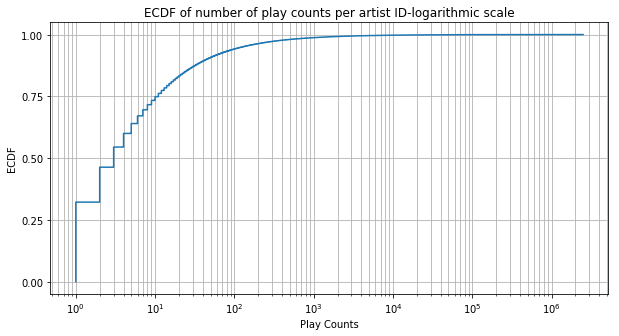

25 % of artists listened to less than 1 playcounts
50 % of artists listened to less than 3 playcounts
75 % of artists listened to less than 11 playcounts
90 % of artists listened to less than 45 playcounts
The maximum value of play counts per artists is 2502130


In [12]:
#Create the dataframe to compute x and y values
pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

#Plot ECDF of number of play counts per userID 
plotFig(Y, yvals, ' artist ID', 1000)
#Plot ECDF of number of play counts per userID with a logarithmic scale
plotFig(Y, yvals, ' artist ID',1000, True)
#Important percentiles info
Percentiles(Y, "artists")

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
Same as the case for users, the total number of play counts per artistID is too large compared to the number of play counts most of the artists have, we limited x_axis to 1000 in order to focus on the transition part of the plot before it converges to value of 1.
<br>More than 75% of artists haved been listened to, less than 11 times. This leads to the conclusion that only a few of the artists are famous.
<br>The logarithmic scale in the second figure gives us a better visualization as well.
</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 10 artists in terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-10 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

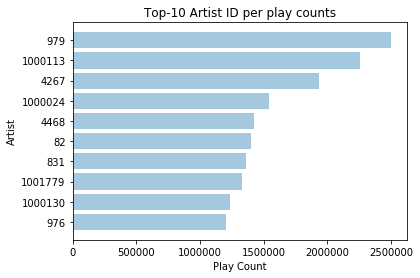

In [13]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[: 10]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()


<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
   These results seem to be reasonable, comparing to the current online platforms like youtube, some videos can have billions of views. Therefore 2500000 is not that huge.
<br><br>
    If our goal is to have a general overview of the data and to see data disparity, ie the repartition of play counts among all the artists, looking to the Top 10 artists is clearly not enough to satisfy our objectives.
<br><br>
    Indeed, there might be ouliers among the top 10 artists which will definitely lead us to a wrong interpretation of the general data. 
<br><br>
    It is worth mentioning that as a characteristic of this dataset, the artist IDs as previously stated, are such that the same artist may have different IDs; this may lead to distorted results/ understaning. <br><br>

</div>


All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [14]:
#Creation of the schema for loading the dataframe
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

#Loading of the artist_data.txt
artistDF = sqlContext.read \
.format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = customSchemaArtist) 
    
# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistDF.cache()
artistDF.show(5)


+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [15]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", "name") > 0].show(20)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()


+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
According to the results displayed in the table, there are many artist IDs that correspond Aerosmith. 
A bunch of them are featurings according to the website (last.fm) from where the data come.
<br>
For instance, consider the ID "10300357" that corresponds to the featuring between "Run-DMC" and "Aerosmith".
This finding raised the question about whether the featuring is considered as a new artist 
or an alias for both artists, which will directly have an impact on the play count statistics.
We took a look on the website.
<br><br>
The artists that have IDs equal to 1000010 and 2082323 seem to point to the same artist, as it may be an spelling error or it may have been entered diffently across different systems.  
We don't need to worry about it, we'll deal with it later.
</div>


To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [16]:
#Creation of the schema for loading the dataframe
customSchemaArtistAlias = StructType([ \
    StructField("mispelledID", LongType(), True), \
    StructField( "standardID", LongType(), True)])

#Loading of the artist_data.txt
artistAliasDF = sqlContext.read \
.format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_alias.txt", schema = customSchemaArtistAlias) 

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()  
artistAliasDF.show(5)


+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    1092764|   1000311|
|    1095122|   1000557|
|    6708070|   1007267|
|   10088054|   1042317|
|    1195917|   1042317|
+-----------+----------+
only showing top 5 rows



#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [17]:

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset
artistAliasDF[ artistAliasDF.mispelledID==1000010 ].show()
artistAliasDF[ artistAliasDF.mispelledID==2082323].show()


+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
+-----------+----------+

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    2082323|   1000010|
+-----------+----------+



In [18]:
featuring=[]
#We try to see how the system deals with featurings: we try to figure it how by looking at the names that contain Run DNC and aerosmith in the previous table
mispelledIDs=[6946007, 10300357, 1140418, 10237208, 6936680, 7032554]

#DataFrame to map each standard ID to the artist name
mispelledNameDF=artistDF.join(artistAliasDF, artistAliasDF.mispelledID==artistDF.artistID, "right_outer").drop(artistDF.artistID)

for artist in mispelledIDs:
     featuring.append(mispelledNameDF[mispelledNameDF.mispelledID==artist].collect())

a=pd.DataFrame(data=featuring)
artistDF[artistDF.artistID==1008164].show()
print("                   Names    mispelledID  standardID")
print(a)

+--------+----------+
|artistID|      name|
+--------+----------+
| 1008164|Run-D.M.C.|
+--------+----------+

                   Names    mispelledID  standardID
                                                0
0            (Aerosmith/RunDMC, 6946007, 1008164)
1        (Run-DMC + Aerosmith, 10300357, 1008164)
2  ([rap]Run DMC and Aerosmith, 1140418, 1008164)
3        (Aerosmith + Run DMC, 10237208, 1008164)
4         (RUN DNC & Aerosmith, 6936680, 1008164)
5      (Aerosmith & Run-D.M.C., 7032554, 1008164)


<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
We decided to see how the application deals with featurings by taking a look at one featuring that we obtain above from the previous query: Run DNC ft. Aerosmith. 
<br>It turns out that all the mispelled IDs of their featuring correspond to  Run DNC's standard ID (1008164) which can lead to a misreprentation of the real number of  of Aerosmith's play counts. 
<br>It is not enough to conclude about the way the application deals with such  problems but we can already see that it may cause some errors in our interpretation. A possible explanation could be that for a particular song there is a principal artist that is considered as the owner.
</div>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [19]:
artistAlias = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1])).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [20]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))


+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.100457 seconds


<div class="alert alert-warning">
<div class="label label-success">Comment:</div><br>
After filtering out records with identical pairs of user-artist ID combinations, (with number of records>1),
we used the userID = 2013279 and artistID = 2003588 combination to show that:<br>
In principle, for the new data to be correct, we do have duplicate pairs (user, artist) with different play counts.
This example out of the several such duplicates that exist, shows that the probem has been resolved.
</div>

In [21]:
#Retrieving the records with same pairs of userID and artistID BEFORE cleaning
duplicate = userArtistDF.groupBy('userID', 'artistID').count().where('count > 1').count()

#Retrieving the records with same pairs of userID and artistID AFTER cleaning
newDuplicate = newUserArtistDF.groupBy('userID', 'artistID').count().where('count > 1').count()

#Showing some records with same pairs of userID and artistID AFTER cleaning
newDuplicateShow = newUserArtistDF.groupBy('userID', 'artistID').count().where('count > 2').show()

print("Before:",duplicate)
print("After: ",newDuplicate)

#Showing an example of duplicates User-Artist records AFTER cleaning with playcounts
newUserArtistDF[(newUserArtistDF['userID'] == 2154304) & (newUserArtistDF['artistID'] == 1036091)].show()

+-------+--------+-----+
| userID|artistID|count|
+-------+--------+-----+
|2013279| 2003588|    3|
|2016156|     691|    3|
|2020797| 1024815|    3|
|2025751| 1329296|    3|
|2056784| 1044794|    3|
|2057925|    3656|    3|
|2067899| 1213823|   12|
|2068581| 1310583|    3|
|2077268| 1001348|   26|
|2102811| 1008764|    3|
|2110904| 1109029|    3|
|2111257| 1015982|    8|
|2115283| 1288628|    9|
|2154304| 1036091|    3|
|2168273|      53|    4|
|2171652| 1014330|    3|
|2171676| 2074905|    3|
|2180801|    4208|    3|
|2188467|    4471|    3|
|2189397| 1192803|    3|
+-------+--------+-----+
only showing top 20 rows

Before: 0
After:  141922
+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2154304| 1036091|        1|
|2154304| 1036091|        1|
|2154304| 1036091|        3|
+-------+--------+---------+



<div class="alert alert-warning">
<div class="label label-success">Comment:</div><br>
Also, below is another way of proving that the probem is indeed resolved:
</div>

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
It can be seen that there were no duplicates with the old dataframe, the new one has a lot more.  This proves that the mispelled Ids were replaced with the standard ones.

</div>


#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [23]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1] , fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()
print(newUserArtistDF.count())

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.340971 seconds
24296858


<div class = "alert alert-success">

<b><div class="label label-success">IDENTIFICATION AND EXPLORATION OF THE PROBLEM WITH "MISPELLED" standardID:</div></b> 
<br><br>

As we came across the problem of certain `artistID`s being mispelled; we tested the attempt of cleaning the data with the `replaceMispelledIDs` method.<br>
As a result of the test, it turns out that a few of the `standardID`s (45 to be precise; can be seen as a result of the below code) also appeared as mispelled IDs in the column `mispelledID`.<br>
Out of the 45 mispelled standard IDs, 11 of them appear as pairs of the form:<br> 
<table>
<tr><th>`mispelledID`</th><th>`standardID`</th></tr>
<tr><td>a</td><td>a</td></tr>
</table>

<br>Such occurances ultimately still correspond to a single standard ID and are coherent.
<br>However, the 34 other `standardID`s that appear in the mispelled list cause chains of ID references as displayed below:
<br>
<table>
<tr><th>`mispelledID`</th><th>`standardID`</th></tr>
<tr><td>a</td><td>b</td></tr>
<tr><td>b</td><td>c</td></tr>
</table>

<br>Such chains have to be resolved such that eventually, when artist IDs are corrected by replacing the mispelled with the standard, each artist can be identified by a uniform coherent name and the IDs are logically sound.
<br>The below cells provide examples of the situation described here.
</div>

<div class = 'alert alert-success'>

<b><div class="label label-success">RESOLUTION of the "mispelled" `standardID` problem:</div></b> 
<br><br>

The chains of ID references of the form are resolved by replacing IDs with the standard ID in the last record of the chain; logically considering that this is "truly" the correct standard ID.<br>
<table>
<tr><th>`mispelledID`</th><th>`standardID`</th></tr>
<tr><td>a</td><td>b</td></tr>
<tr><td>b</td><td>c</td></tr>
</table>

<br>Therefore, after resolution, the records will be of the below form: (thus replacing all the `standardID`s of the `mispelledID`s with the true `standardID`.
<br>
<table>
<tr><th>`mispelledID`</th><th>`standardID`</th></tr>
<tr><td>a</td><td>c</td></tr>
<tr><td>b</td><td>c</td></tr>
</table>

The below cell implements this cleaning method, thus rendering correct mappings between misplelled and standard IDs
</div>

In [29]:

#A list of the mispelledIDs
mispelledID_list = list(artistAliasDF.select('mispelledID').collect())
#A list of the standardIDs
standardID_list = list(artistAliasDF.select('standardID').collect())
#A list of standardIDs that are also mispelled
mispelled_std_IDs = [x[0] for x in list(set(mispelledID_list) & set(standardID_list))]
print("standardID that occur also in the mispelledID column:",mispelled_std_IDs)


standardID that occur also in the mispelledID column: [1111535, 1004143, 1257504, 2684, 1009175, 1245218, 6817660, 1016035, 1018110, 1199012, 1240778, 1006347, 754, 1006322, 1167860, 15, 576, 1013851, 1053468, 1073602, 1011293, 1164008, 1009640, 1008798, 6995268, 2137055, 1014609, 1007544, 1003219, 1044091, 1016162, 1001864, 10151717, 1136715, 6603878, 1235697, 1043468, 6646349, 2061299, 1206735, 1042639, 1014175, 1256402, 1252142, 1014100]


In [26]:
import copy

#A code for cleaning the dict
cleanArtistAlias=copy.deepcopy(artistAlias)

#A function to clean the artistIDs mappings
for mispStdId in mispelled_std_IDs:
    if mispStdId in list(cleanArtistAlias.keys()):
        c=cleanArtistAlias[mispStdId]
        for k in cleanArtistAlias.keys():
            if cleanArtistAlias[k]==mispStdId:
                cleanArtistAlias[k]=c
                
for mispStdId in mispelled_std_IDs:
    count=0
    if mispStdId in list(cleanArtistAlias.keys()):
        c=cleanArtistAlias[mispStdId]
        for k in cleanArtistAlias.keys():
#             if k==mispStdId: cleanArtistAlias.pop(k)
            if cleanArtistAlias[k]==mispStdId:
                cleanArtistAlias[k]=c
                count+=1
    counts.append(count)


#The below code is to extract a list of all standardID that occur also in the mispelledID column 
value = { k : artistAlias[k] for k in set(artistAlias) - set(cleanArtistAlias) }
print("standardID that occur also in the mispelledID column: ", value)


standardID that occur also in the mispelledID column:  {}


In [40]:
#Taking 1111535 from the above list of mispelled standardIDs to show the chain that we will clean
print("Taking 1111535 from the above list of mispelled standardIDs to show the chain that we will clean")
for key, val in artistAlias.items():
    if key==1111535 or val==1111535:
        print("misplledId:", key, "standardID: ",val)
        
print("\n")
#Displaying the names of the IDs that appear in the chain to show that they should have one coherent standard name 
print("Displaying the names of the IDs that appear in the chain to show that they should have one coherent standard name")
artistDF[artistDF.artistID==7012272 ].show()
artistDF[artistDF.artistID==3554].show()
artistDF[artistDF.artistID==1111535 ].show()


print("After cleaning artistAlias by replacing the mispelled standardIDs with the true standardIDs:")
for key, val in cleanArtistAlias.items():
    if key==7012272 or key==1111535 :
        print("misplledId:", key, "standardID: ",val)

Taking 1111535 from the above list of mispelled standardIDs to show the chain that we will clean
misplledId: 7012272 standardID:  1111535
misplledId: 1111535 standardID:  3554


Displaying the names of the IDs that appear in the chain to show that they should have one coherent standard name
+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 7012272|Sarah Vaughn and ...|
+--------+--------------------+

+--------+-------------+
|artistID|         name|
+--------+-------------+
|    3554|Sarah Vaughan|
+--------+-------------+

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1111535|Sarah Vaughan and...|
+--------+--------------------+

After cleaning artistAlias by replacing the mispelled standardIDs with the true standardIDs:
misplledId: 7012272 standardID:  3554
misplledId: 1111535 standardID:  3554


<div class="alert alert-success">
Using the cleaned artistAlias dictionnary, we can update the userArtistDF by using the `disambiguate` function and then build a new model.
</div>

<div class = "alert alert-warning">
We now test the above cleaning to see if the chains have been resolved; by checking the IDs that have been replaced.
</div>

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
Broadcasting the artistAlias which is used by every single map task allows to reduce the communication cost which results in a much fatser job. The running time decreases by a factor of 10!  
</div>

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [41]:
#ADD CODE for using cleanNewUserArtistDF and print
uniqueArtists = newUserArtistDF.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)


Total n. of artists:  1568126


<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
As mispelled IDs were corrected to correspond to specific standard IDs, the total number of artists decreased by 62902 after cleaning the data. <br>
Since many mispelled artistIDs were replaced by certain standardIDs, this count has reduced.
</div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artists?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

### Top-10 artists in terms of play counts

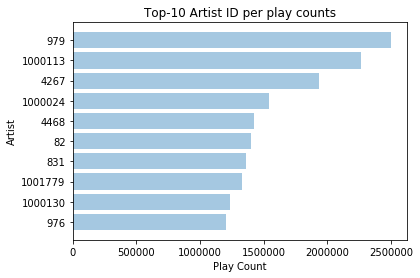

In [43]:
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy("artistID").sum("playCount" ).orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()


### Top-10 artists in terms of audience size

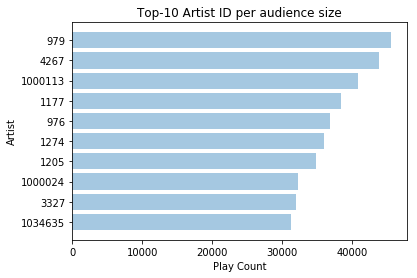

In [44]:
# calculate top-10 artists in term of audience size
top10ArtistsAudSize = newUserArtistDF.groupBy("artistID").agg(countDistinct("userID")).orderBy("count(DISTINCT userID)", ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsAudSize)
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

<div class = 'alert alert-warning'>

<div class="label label-success">INFERENCE:</div><br>
Here we observe that the users are more uniformly distributed over the top 10 artists than the playcounts.<br>
This can be because of the reason that, user activity is a highly variable parameter which not only depends on several specific characteristics of individuals; but also on the characteristics of the songs/artists.<br><br> To be more clear:<br>
Number of users per artist: This measure indicates the total number of users who have listened to at least one song of the artist. <br>
Number of playcounts per artist: This measure indicates the total number of playcounts the artist has; over all his songs and users (who have actually listened to his songs).
<br>
Since all top 10 artists have a fairly high number of users who have listened to at least one of their songs; the audience size is seems to be uniform and decreases gracefully down the ladder of top 10 artists.
<br>
On the other hand, the number of playcounts per artist is more dependent on the intrinsic properties of the artist's song and user preferences/ level of activity which are highly variable parameters.<br><br>
Although very good (most popular - top 3) artists manage to maintain nearly similar graphs, with playcounts as well as audience size; the playcounts show one small rapid decrease at the top 4th artist and then uniformly decreases further.
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

### Top 10 users in term of play counts 

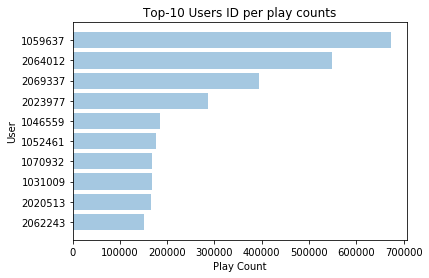

In [45]:
# calculate top 10 users in term of play counts
top10UsersByPlayCount = newUserArtistDF.groupBy("userID").sum("playCount" ).orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()


### Top 10 users in term of curiosity

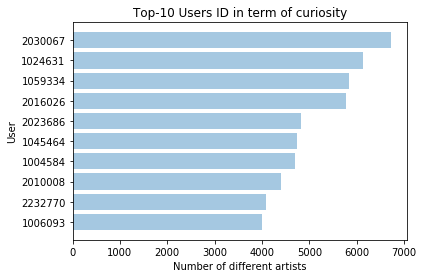

In [46]:
# calculate top 10 users in term of curiosity
top10UsersByCuriosity = newUserArtistDF.groupBy("userID").agg(countDistinct("artistID")).orderBy("count(DISTINCT artistID)", ascending=0).take(10)
y_pos = range(len(top10UsersByCuriosity))

pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Number of different artists')
plt.ylabel('User')
plt.title('Top-10 Users ID in term of curiosity')
plt.show()

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
If a user belongs to a list of top 10 users, then it implies that the user is highly active; either in terms of the number of times the user plays songs or in terms of the variety and number of artists the user listens to.
<br>
From the above graphs it can be said even though a user may be higly active, it is not necessary that the user is curious (in the sense that, it implies that the user might not be open to listen to a variety of artists). Therefore, top 10 users by playcounts are potentially "loyal" users of specific artists/ songs of artists. 
<br>Rendering recommendations for such users while using content-based systems is more simpler  (as the deciding factor of recommendation now is narrowed down to similar features of songs/artists the user usually listens to).
<br><br>On the other hand, the graph of top 10 users in terms of curiosity shows that some users have listened to over 6000 different artists. With the unavailability of time data, this seems to be a huge number for the number of artists a single user has listened to. With time data, logical conclusions can be made.
<br>Also, it can be said that rendering recommendations for such users might be potentially more complex while using content-based systems; as now a number of other depending features have to be taken into consideration for good recommendations.
</div>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [47]:

rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( lambda s: xtractFields(s))
    
                    # fileter out the special tuples
                    .filter( lambda s: s!=(-1,-1) )
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )


#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

In [48]:

bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID, artistID)
    return (userID, finalArtistID, count)

userArtistDataRDD = rawUserArtistData.map(lambda line: disambiguate(line))
userArtistDataRDD.take(5)


[('1000002', '1', '55'),
 ('1000002', '1000006', '33'),
 ('1000002', '1000007', '8'),
 ('1000002', '1000009', '144'),
 ('1000002', '1000010', '314')]

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [49]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [52]:

# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records
t0 = time()
allData = userArtistDataRDD.map(lambda r: ((r[0],r[1]),r[2])).reduceByKey(_+_).map(lambda r: Rating(r[0][0], r[0][1], r[1])).repartition(8).cache()
t1 = time()
print('Time taken = ', t1-t0)

allData.take(5)

Time taken =  0.04969477653503418


[Rating(user=1001456, product=1021260, rating=2.0),
 Rating(user=1001516, product=1027924, rating=1.0),
 Rating(user=1001604, product=1050683, rating=13.0),
 Rating(user=1001606, product=1152210, rating=2.0),
 Rating(user=1001638, product=1002686, rating=2.0)]

<div class="alert alert-warning">
<div class="label label-success">Comment:</div><br>
We decided to use 8 partitions after trying different values (4, 8, 10, 12) as it was the fastest. <br>
The function Repartition returns a new RDD that has exactly numPartitions partitions. It can increase or decrease the level of parallelism in the RDD depending on the number of partitions we choose. Internally, this uses a shuffle to redistribute data. This can explain why for big values like 10 and 12 there are large number of small partitions which causes the shuffle phase to slow down.  
</div>

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [85]:
alpha=1
rank=10
lambda_=0.01
iterations=5

t0 = time()
model = ALS.trainImplicit(allData, rank, alpha, lambda_, iterations)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 41.094308 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [86]:
t0=time()
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc , "lastfm_model.spark")
t1=time()
print("finish saving model in %f secs" % (t1-t0))

Deleted lastfm_model.spark
finish saving model in 6.063663 secs


In [87]:
#We want to show the file we've just saved into hdfs
!hdfs dfs -ls

Found 1 items
drwxr-xr-x   - aml24 supergroup          0 2018-03-29 18:19 lastfm_model.spark


<div class="alert alert-warning" >
<div class="label label-success">Comment:</div><br>
We see that the has been saved on hdfs but with 0 size which is strange but the model seems to work for the recommendations below.
   </div>

#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [88]:
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))


finish loading model in 1.121231 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [89]:

model.userFeatures().first()


(277,
 array('d', [0.00517608504742384, 0.007210332900285721, -0.007920615375041962, 0.003319806419312954, -0.0058334022760391235, 0.0007743655005469918, -0.0021333748009055853, 0.0022061807103455067, -0.005591651424765587, -0.014979466795921326]))

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [90]:
# Make five reccommendations to user 1059637 who is the first among the top-10 users in term of number of playcounts
recommendations = (model.recommendProducts(1059637, 5))
recommendations[: 5]
# construct set of recommended artists
recArtist = set(list(elt[1] for elt in recommendations))


In [91]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)


In [92]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(artistNames).values().collect()

print(recList)


['Guided by Voices', 'Something Corporate', 'My Chemical Romance', 'System of a Down', 'Mates of State']


<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
We noticed that the recommendations change on each execution (each time we load a new model). 
The trainImplicit function trains a matrix factorization model given an RDD of ‘implicit preferences’ of users for a subset of artists. <br>
TrainImplicit uses a seed parameter which is a random seed for initial matrix factorization model. In our case since we didn't specify a value for it, the default value is None and corresponds to the system time. This implies that the model depends on a randomn variable based on system time and that explains the fact that it changes each time we load it. This also explains how the recommandations are randomnly picked.
</div>




<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [93]:

def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [94]:
trainData, cvData = allData.randomSplit([0.9,0.1])
trainData.cache()
cvData.cache()


PythonRDD[675] at RDD at PythonRDD.scala:48

In [95]:
iterations=5
lambda_=0.01
alpha=1
rank=10

t0 = time()
model = ALS.trainImplicit(trainData, rank, alpha, lambda_, iterations)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 51.671149 secs


#### Area under the ROC curve: a function to compute it

In [96]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [97]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [98]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))


auc= 0.6764267243929207
finish in 47.845617 seconds


#### Question 9.3
<div class="alert alert-info">
Now we have the AUC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple popularity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [99]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x,y: x+y).collectAsMap())

def predictMostListened(allData):
     return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))


In [100]:
predictMostListened(allData).take(2)

[Rating(user=1001456, product=1021260, rating=53138.0),
 Rating(user=1001516, product=1027924, rating=5.0)]

In [103]:
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print(auc)


0.9378438727865905


## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given parameters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [104]:
evaluations = []
iteration=1
for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank)
            
            auc = calculateAUC( cvData , bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort( key= lambda x: -x[1] )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()


Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000
                    0         1
0   (10, 0.0001, 1.0)  0.964013
1     (10, 1.0, 40.0)  0.962804
2      (10, 1.0, 1.0)  0.962661
3  (10, 0.0001, 40.0)  0.961754
4      (50, 1.0, 1.0)  0.945157
5     (50, 1.0, 40.0)  0.945070
6  (50, 0.0001, 40.0)  0.945022
7   (50, 0.0001, 1.0)  0.944516


PythonRDD[675] at RDD at PythonRDD.scala:48

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [105]:
iterations=5
rank=evaluations[0][0][0]
lambda_=evaluations[0][0][1]
alpha=int(evaluations[0][0][2])

model = ALS.trainImplicit( trainData, rank, iterations, lambda_, alpha)
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID, 5)

recommendedProductIDs = set(list(row.product for row in recommendations))

recList = artistByID.filter(lambda line: line[0] in recommendedProductIDs).values().collect()
print(recList)

unpersist(model)


['50 Cent', 'Snoop Dogg', 'Nas', 'Jay-Z', '2Pac']


# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)

<div class="alert alert-success">
<b><div class="label label-success">NEW COLLABORATIVE FILTERING ALGORITHM BASED ON USER CLUSTERING AND VOTING</div></b> 
<br><br>

Here we develop an other way to compute the collaborative filtering algorithm by using K-means clustering and neighbors' voting. The clustering part aims to create several groups of users with as similar tastes as possible.
<br><br>
Instead of using the similarity measuring, this method is based on Minkowski Distance of order &gamma;


All users correspond to points in the $n-dimensional space$. 
<br> We have $MaxUserId$ number of users.<br> $n$ will be the number of artists. This is how the data should look like:<br> 
$User1= (r1_1, r1_2,..., r1_n)$ 
<br>$User2= (r21, r22,..., r2n)$
<br>$...$
<br>
$Userm= (rm_1, rm_2,..., rm_n)$ 
<br>
where $ri_k$ denotes the normalized rating of user i on $k^t$$^h$ item.
<br>
<br>
<center>
$ d(user_i, user_j) = \sqrt[\gamma \,]{ \sum_{k=1}^n (ri_k -rj_k)^\gamma} $
</center>

 
 
</div>
